# Calculating OMI with rotation

Use this file to generate the rotated OMI as described in Weidman, S., Kleiner, N., and Kuang, Z., 2022. A rotation procedure to improve seasonally varying Empirical Orthogonal Function bases for MJO indices, submitted to *Geophysical Research Letters*. (preprint can be found at https://doi.org/10.1002/essoar.10511626.1). 

The complete OMI algorithm is described in Kiladis, G.N., J. Dias, K.H. Straub, M.C. Wheeler, S.N. Tulich, K. Kikuchi, K.M. Weickmann, and M.J. Ventrice, 2014: A Comparison of OLR and Circulation-Based Indices for Tracking the MJO. Mon. Wea. Rev., 142, 1697–1715, https://doi.org/10.1175/MWR-D-13-00301.1

General OMI functions from mjoindices python package published by Hoffmann, C.G., Kiladis, G.N., Gehne, M. and von Savigny, C., 2021. A Python Package to Calculate the OLR-Based Index of the Madden- Julian-Oscillation (OMI) in Climate Science and Weather Forecasting. Journal of Open Research Software, 9(1), p.9. DOI: http://doi.org/10.5334/jors.331 which can be found on github in at https://github.com/cghoffmann/mjoindices.

Rotation algorithm functions found at https://github.com/sweidy/eof_rotation at eof_rotation.py. Additional file rotation_plotting_tools.py in the same folder is used for organizing and plotting the PCs. 

In [1]:
from pathlib import Path
import os.path
import inspect

import mjoindices.olr_handling as olr
import mjoindices.omi.omi_calculator as omi
import mjoindices.empirical_orthogonal_functions as eof
import mjoindices.principal_components as pc
import mjoindices.evaluation_tools as eval_tools
import mjoindices.tools as tools
import mjoindices.omi.wheeler_kiladis_mjo_filter as wkfilter
import mjoindices.eof_rotation as omir
import mjoindices.rotation_plotting_tools as omp

import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['font.size'] = '16'

Change file location here for OLR dataset

In [2]:
OLR_path = Path(os.path.abspath('')) / 'observed_data' / 'olr.day.mean.nc'

Create a path for calculated EOFs and Figures. Change here if desired. 

In [2]:
eofs_dir = Path(os.path.abspath('')) / 'EOFs'

In [3]:
fig_dir = Path(os.path.abspath('')) / 'figures'

In [4]:
pc_dir = Path(os.path.abspath('')) / 'PCs'

Load in OLR dataset

In [6]:
raw_olr = olr.load_noaa_interpolated_olr(OLR_path)

Restrict the OLR dataset to the dates used in the paper. This can be changed to use a longer time period, but EOF results will change slightly. 

In [8]:
time_start = np.datetime64('1979-01-01')
time_end = np.datetime64('2012-12-31')

In [9]:
shorter_olr = olr.restrict_time_coverage(raw_olr, time_start, time_end)

Interpolate the dataset to the same grid as used in the original OMI calcluation (not required, but testing has only been done using the interpolated grid). 

In [10]:
interpolated_olr = olr.interpolate_spatial_grid_to_original(shorter_olr)

Calculate the EOFs using the rotation algorithm. This may take an hour or more, especially on a personal computer. 

In [11]:
"""
    :param olrdata: The OLR dataset, from which OMI should be calculated. Note that OLR values are assumed to be given
        in positive values. The spatial grid of the OLR datasets defines also the spatial grid of the complete OMI
        calculation.
    :param implementation: eofs_package (py:mod:eofs) or internal method
    :param sign_doy1reference: Switch signs of EOF to align with 2014 paper (observations) so all days are consistent.
    :param strict_leap_year_treatment: default for no leap years or non-standard calendar should be False`.

"""  

rot_eofs = omir.calc_eofs_from_olr_with_rotation(interpolated_olr, 
                                 implementation='eofs_package', 
                                 sign_doy1reference=True,
                                 strict_leap_year_treatment=False)

Smooth data temporally and longitudinally...
Filtering for latitude:  -20.0
Filtering for latitude:  -17.5
Filtering for latitude:  -15.0
Filtering for latitude:  -12.5
Filtering for latitude:  -10.0
Filtering for latitude:  -7.5
Filtering for latitude:  -5.0
Filtering for latitude:  -2.5
Filtering for latitude:  0.0
Filtering for latitude:  2.5
Filtering for latitude:  5.0
Filtering for latitude:  7.5
Filtering for latitude:  10.0
Filtering for latitude:  12.5
Filtering for latitude:  15.0
Filtering for latitude:  17.5
Filtering for latitude:  20.0
Calculating EOFs for DOY 1
Calculating EOFs for DOY 2
Calculating EOFs for DOY 3
Calculating EOFs for DOY 4
Calculating EOFs for DOY 5
Calculating EOFs for DOY 6
Calculating EOFs for DOY 7
Calculating EOFs for DOY 8
Calculating EOFs for DOY 9
Calculating EOFs for DOY 10
Calculating EOFs for DOY 11
Calculating EOFs for DOY 12
Calculating EOFs for DOY 13
Calculating EOFs for DOY 14
Calculating EOFs for DOY 15
Calculating EOFs for DOY 16
Calcu

Calculating EOFs for DOY 269
Calculating EOFs for DOY 270
Calculating EOFs for DOY 271
Calculating EOFs for DOY 272
Calculating EOFs for DOY 273
Calculating EOFs for DOY 274
Calculating EOFs for DOY 275
Calculating EOFs for DOY 276
Calculating EOFs for DOY 277
Calculating EOFs for DOY 278
Calculating EOFs for DOY 279
Calculating EOFs for DOY 280
Calculating EOFs for DOY 281
Calculating EOFs for DOY 282
Calculating EOFs for DOY 283
Calculating EOFs for DOY 284
Calculating EOFs for DOY 285
Calculating EOFs for DOY 286
Calculating EOFs for DOY 287
Calculating EOFs for DOY 288
Calculating EOFs for DOY 289
Calculating EOFs for DOY 290
Calculating EOFs for DOY 291
Calculating EOFs for DOY 292
Calculating EOFs for DOY 293
Calculating EOFs for DOY 294
Calculating EOFs for DOY 295
Calculating EOFs for DOY 296
Calculating EOFs for DOY 297
Calculating EOFs for DOY 298
Calculating EOFs for DOY 299
Calculating EOFs for DOY 300
Calculating EOFs for DOY 301
Calculating EOFs for DOY 302
Calculating EO

Save EOFs in your defined EOF folder. 

In [12]:
rot_eofs.save_all_eofs_to_npzfile(eofs_dir / 'EOFs_rotated.npz')

Similarly, calculate the EOFs from the original OMI algorithm. Change interpolate_eofs to True to directly reproduce the method from Kiladis et al., 2014. This will interpolate the EOFs during the beginning of November. This also may take up to an hour or more. 

In [12]:
norot_eofs = omi.calc_eofs_from_olr(interpolated_olr,
                        implementation="eofs_package",
                        sign_doy1reference=True,
                        interpolate_eofs=False,
                        strict_leap_year_treatment=False)

Smooth data temporally and longitudinally...
Filtering for latitude:  -20.0
Filtering for latitude:  -17.5
Filtering for latitude:  -15.0
Filtering for latitude:  -12.5
Filtering for latitude:  -10.0
Filtering for latitude:  -7.5
Filtering for latitude:  -5.0
Filtering for latitude:  -2.5
Filtering for latitude:  0.0
Filtering for latitude:  2.5
Filtering for latitude:  5.0
Filtering for latitude:  7.5
Filtering for latitude:  10.0
Filtering for latitude:  12.5
Filtering for latitude:  15.0
Filtering for latitude:  17.5
Filtering for latitude:  20.0
Calculating EOFs for DOY 1
Calculating EOFs for DOY 2
Calculating EOFs for DOY 3
Calculating EOFs for DOY 4
Calculating EOFs for DOY 5
Calculating EOFs for DOY 6
Calculating EOFs for DOY 7
Calculating EOFs for DOY 8
Calculating EOFs for DOY 9
Calculating EOFs for DOY 10
Calculating EOFs for DOY 11
Calculating EOFs for DOY 12
Calculating EOFs for DOY 13
Calculating EOFs for DOY 14
Calculating EOFs for DOY 15
Calculating EOFs for DOY 16
Calcu

Calculating EOFs for DOY 269
Calculating EOFs for DOY 270
Calculating EOFs for DOY 271
Calculating EOFs for DOY 272
Calculating EOFs for DOY 273
Calculating EOFs for DOY 274
Calculating EOFs for DOY 275
Calculating EOFs for DOY 276
Calculating EOFs for DOY 277
Calculating EOFs for DOY 278
Calculating EOFs for DOY 279
Calculating EOFs for DOY 280
Calculating EOFs for DOY 281
Calculating EOFs for DOY 282
Calculating EOFs for DOY 283
Calculating EOFs for DOY 284
Calculating EOFs for DOY 285
Calculating EOFs for DOY 286
Calculating EOFs for DOY 287
Calculating EOFs for DOY 288
Calculating EOFs for DOY 289
Calculating EOFs for DOY 290
Calculating EOFs for DOY 291
Calculating EOFs for DOY 292
Calculating EOFs for DOY 293
Calculating EOFs for DOY 294
Calculating EOFs for DOY 295
Calculating EOFs for DOY 296
Calculating EOFs for DOY 297
Calculating EOFs for DOY 298
Calculating EOFs for DOY 299
Calculating EOFs for DOY 300
Calculating EOFs for DOY 301
Calculating EOFs for DOY 302
Calculating EO

In [14]:
norot_eofs.save_all_eofs_to_npzfile(eofs_dir / 'EOFs_unrotated.npz')

If you have already calculated the EOFs, you can reload them from your EOF folder. 

In [5]:
eof_rot = eofs_dir / 'EOFs_rotated.npz'
rot_eofs = eof.restore_all_eofs_from_npzfile(eof_rot)

eof_norot = eofs_dir / 'EOFs_unrotated.npz'
norot_eofs = eof.restore_all_eofs_from_npzfile(eof_norot)

Now use the EOFs to calculate the principal components. The time variable is restricted to the same years as the EOF calculation. If you removed leap years earlier, the PCs will also use no leap years. 

In [16]:
pcs_rot = omi.calculate_pcs_from_olr(raw_olr,
                                 rot_eofs,
                                 time_start,
                                 time_end,
                                 use_quick_temporal_filter=False)

pcs_norot = omi.calculate_pcs_from_olr(raw_olr,
                                 norot_eofs,
                                 time_start,
                                 time_end,
                                 use_quick_temporal_filter=False)

Smooth data temporally and longitudinally...
Filtering for latitude:  -20.0
Filtering for latitude:  -17.5
Filtering for latitude:  -15.0
Filtering for latitude:  -12.5
Filtering for latitude:  -10.0
Filtering for latitude:  -7.5
Filtering for latitude:  -5.0
Filtering for latitude:  -2.5
Filtering for latitude:  0.0
Filtering for latitude:  2.5
Filtering for latitude:  5.0
Filtering for latitude:  7.5
Filtering for latitude:  10.0
Filtering for latitude:  12.5
Filtering for latitude:  15.0
Filtering for latitude:  17.5
Filtering for latitude:  20.0
Smooth data temporally and longitudinally...
Filtering for latitude:  -20.0
Filtering for latitude:  -17.5
Filtering for latitude:  -15.0
Filtering for latitude:  -12.5
Filtering for latitude:  -10.0
Filtering for latitude:  -7.5
Filtering for latitude:  -5.0
Filtering for latitude:  -2.5
Filtering for latitude:  0.0
Filtering for latitude:  2.5
Filtering for latitude:  5.0
Filtering for latitude:  7.5
Filtering for latitude:  10.0
Filterin

In [17]:
pcs_rot.save_pcs_to_txt_file(pc_dir / 'PCs_rotated.txt')
pcs_norot.save_pcs_to_txt_file(pc_dir / 'PCs_unrotated.txt')

If you have already calculated PCs, you can reload them here. 

In [6]:
pc_rot_path = pc_dir / 'PCs_rotated.txt'
pcs_rot = pc.load_pcs_from_txt_file(pc_rot_path)

pc_norot_path = pc_dir / 'PCs_unrotated.txt'
pcs_norot = pc.load_pcs_from_txt_file(pc_norot_path)

Organize the PCs into Pandas dataframes for plotting purposes. The PCs must be saved in the specified path. 

In [7]:
pcs_norot_org = omp.organize_pc_dataframe(pc_norot_path)
pcs_rot_org = omp.organize_pc_dataframe(pc_rot_path)

The below cells will use the EOFs calculated above to generate figures similar to those found in the paper. Parameters can be modified to reproduce the supplemental figures. 

Text(0, 0.5, 'Angle from DOY1')

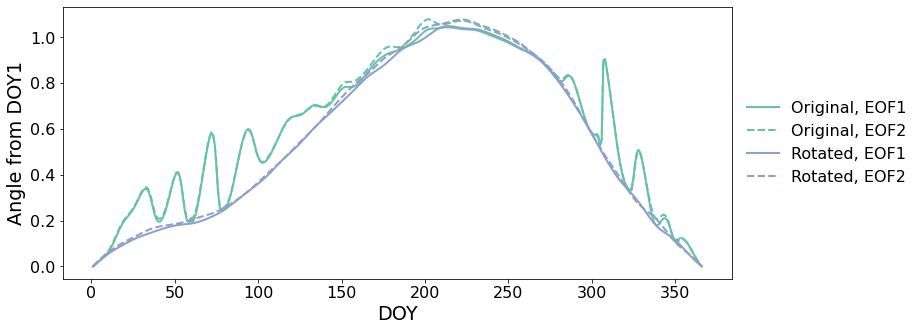

In [21]:
# Figure 1

eof_list = [norot_eofs, rot_eofs]
eof_list_names = ['Original', 'Rotated']
colors = [(102/255,194/255,165/255), 
          (141/255,160/255,203/255)] #https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3

list_of_doys = tools.doy_list()

fig = plt.figure(figsize=(12,5))

for t in range(len(eof_list)):
    
    doy1 = eof_list[t].eofdata_for_doy(1)
    doy_angle = np.empty([2,len(list_of_doys)])
    
    for d in range(len(list_of_doys)):
        
        doyn = eof_list[t].eofdata_for_doy(d+1)
        
        # calculate angle between EOFs on each DOY and EOFs on DOY 1
        doy_angle[0,d] = omir.angle_btwn_vectors(doy1.eof1vector, doyn.eof1vector)
        doy_angle[1,d] = omir.angle_btwn_vectors(doy1.eof2vector, doyn.eof2vector)
        
    plt.plot(list_of_doys, doy_angle[0,:], color=colors[t], linewidth=2, 
             label=f'{eof_list_names[t]}, EOF1')
    plt.plot(list_of_doys, doy_angle[1,:], color=colors[t], linestyle='--', linewidth=2, 
             label=f'{eof_list_names[t]}, EOF2')
        
plt.legend(loc='center left', frameon=False, bbox_to_anchor=(1,.5))
        
plt.xlabel('DOY', size='large')
plt.ylabel('Angle from DOY1', size='large')

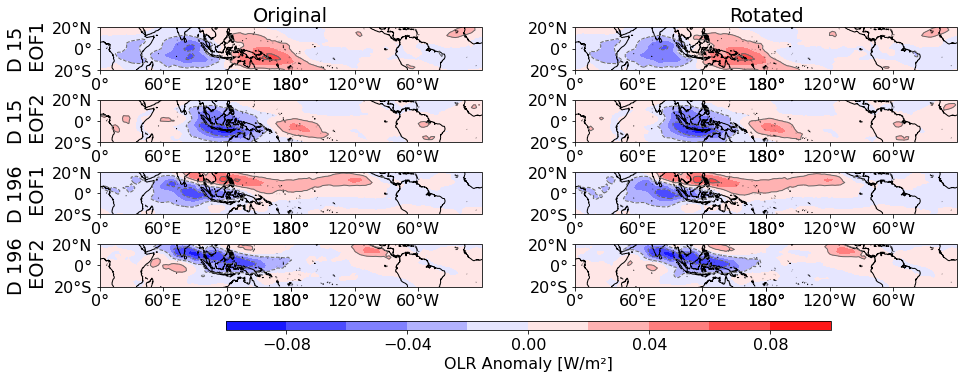

In [22]:
# Figure 2a

doy1 = rot_eofs.eofdata_for_doy(1)

orig_lat = doy1.lat
orig_long = doy1.long

blank_map = np.zeros([orig_lat.size, orig_long.size])
blank_map_cyclic, long = add_cyclic_point(blank_map, coord=orig_long)

orig_type = norot_eofs
rot_type = rot_eofs

eof_nums = ['EOF1', 'EOF2']
eof_types = ['Original', 'Rotated']
plotting_doys = [15, 15, 196, 196] # January 15 and July 15
plot_labels = []
for d in plotting_doys:
    for i in eof_nums:
        plot_labels.append(f'{i} DOY {d}')

fig, axs = plt.subplots(len(plotting_doys), len(eof_types), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                        figsize=(14,6))

# plot lat lon map of EOFs at specified plotting days
for d in range(len(plotting_doys)):
    
    doyn_orig = orig_type.eofdata_for_doy(plotting_doys[d])
    doyn_rot = rot_type.eofdata_for_doy(plotting_doys[d])
    
    if d%2 == 0:
        eof_set = np.array([doyn_orig.eof1map, doyn_rot.eof1map])
    else:
        eof_set = np.array([doyn_orig.eof2map, doyn_rot.eof2map])
    
    for i, eof_i in enumerate(eof_types):
        
        plotting_map = add_cyclic_point(np.squeeze(eof_set[i,:,:]), axis=1)
        
        e = axs[d,i].contour(long, orig_lat, plotting_map, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.1, 0.11, 0.04), 
                      transform=ccrs.PlateCarree())
        e = axs[d,i].contourf(long, orig_lat, plotting_map,
                      levels=np.arange(-0.1, 0.11, 0.02), cmap=plt.cm.get_cmap("bwr"), 
                      transform=ccrs.PlateCarree())
        
        axs[d,i].coastlines()
    
        # Define the xticks for longitude
        axs[d,i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[d,i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[d,i].set_yticks(orig_lat[::8], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[d,i].yaxis.set_major_formatter(lat_formatter)

for ax, col in zip(axs[0], eof_types):
    ax.set_title(col)
    
for ax, row, n in zip(axs[:,0], plotting_doys, (1,2,1,2)):
    ax.set_ylabel(f'D {row}\n EOF{n}', rotation=90, size='large')
    
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.3, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.7)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(e, cax=cbar_ax,orientation='horizontal', label="OLR Anomaly [W/m²]")

########## Summary of EOF comparison for all DOYs (EOF 1)
Worst Correlation (at DOY 308): 0.6904
Mean Correlation for all DOYs: 0.9657
Worst 99% percentile (at DOY 308): 0.0625
Worst 68% percentile (at DOY 308): 0.0094
########## Summary of EOF comparison for all DOYs (EOF 2)
Worst Correlation (at DOY 308): 0.6884
Mean Correlation for all DOYs: 0.9653
Worst 99% percentile (at DOY 308): 0.0506
Worst 68% percentile (at DOY 308): 0.0118


Text(0, 0.5, 'Correlation \ncoefficient')

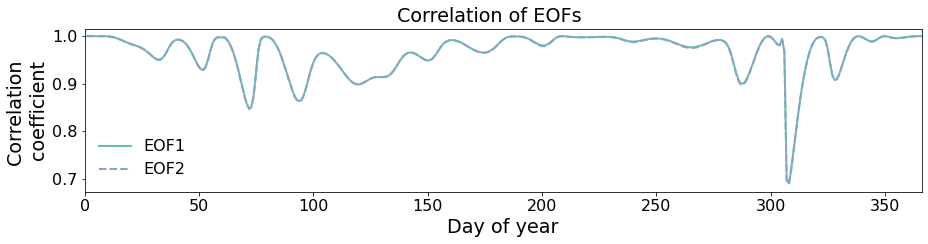

In [10]:
# Figure 2b

doys = tools.doy_list()
do_print = True # print out similarity statistics between EOFs
exclude_doy366 = False

orig_type = norot_eofs
rot_type = rot_eofs
    
xlim = (0, doys[-1])
# calculate statistics and correlation between original and rotated EOFs
(corr_1, diff_mean_1, diff_std_1, diff_abs_percent68_1, diff_abs_percent95_1, diff_abs_percent99_1)\
    = eval_tools.calc_comparison_stats_for_eofs_all_doys(orig_type, rot_type, exclude_doy366=exclude_doy366, eof_number=1,
                                              percentage=False, do_print=do_print)
(corr_2, diff_mean_2, diff_std_2, diff_abs_percent68_2, diff_abs_percent95_2, diff_abs_percent99_2)\
    = eval_tools.calc_comparison_stats_for_eofs_all_doys(orig_type, rot_type, exclude_doy366=exclude_doy366, eof_number=2,
                                              percentage=False, do_print=do_print)

fig, axs = plt.subplots(1, 1, clear=True, figsize=(15, 3))
plt.subplots_adjust(hspace=0.3)

fig.suptitle("Correlation of EOFs")

ax = axs
p11, = ax.plot(doys, corr_1, label="EOF1", color=(102/255,194/255,165/255), linewidth=2)
p12, = ax.plot(doys, corr_2, '--', label="EOF2", color=(141/255,160/255,203/255), linewidth=2)
ax.set_xlim(xlim)
ax.legend(handles=[p11, p12], frameon=False)
ax.set_xlabel("Day of year", size='large')
ax.set_ylabel("Correlation \ncoefficient", size='large')
#ax.set_ylim((0, 1.1))



/n/home04/sweidman/.conda/envs/mjo_env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


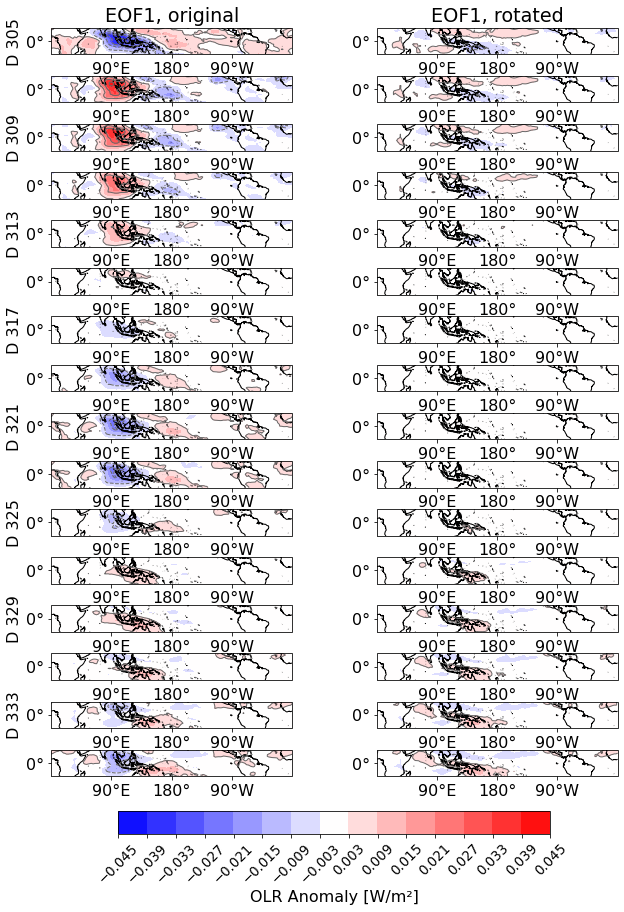

In [11]:
# Figure 3

eof_n = 1 # change here to plot EOF2
doy1 = rot_eofs.eofdata_for_doy(1)

orig_lat = doy1.lat
orig_long = doy1.long

blank_map = np.zeros([orig_lat.size, orig_long.size])
blank_map_cyclic, long = add_cyclic_point(blank_map, coord=orig_long)

orig_type = norot_eofs
rot_type = rot_eofs

# plot over November
doy_start = 305
doy_end = 335

eof_nums = [f'EOF{eof_n}, original', f'EOF{eof_n}, rotated']
plotting_doys = range(doy_start,doy_end+1,2) # every other day 

fig, axs = plt.subplots(len(plotting_doys),len(eof_nums), 
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, 
                        figsize=(10,16))

# calculate mean over period
orig_mean = omp.calc_mean_eof(orig_type, doy_start, doy_end)
rot_mean = omp.calc_mean_eof(rot_type, doy_start, doy_end)

for d in range(len(plotting_doys)):
    
    doyn_orig = orig_type.eofdata_for_doy(plotting_doys[d])
    doyn_rot = rot_type.eofdata_for_doy(plotting_doys[d])
    
    # calculate anomaly from period mean
    if eof_n == 1:
        eof_set = np.array([doyn_orig.eof1map - orig_mean[:,:,0], doyn_rot.eof1map - rot_mean[:,:,0]])
    elif eof_n == 2:
        eof_set = np.array([doyn_orig.eof2map - orig_mean[:,:,1], doyn_rot.eof2map - rot_mean[:,:,1]])
    
    for i, eof_i in enumerate(eof_nums):
        
        plotting_map = add_cyclic_point(np.squeeze(eof_set[i,:,:]), axis=1)
        
        e = axs[d,i].contour(long, orig_lat, plotting_map, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.045, 0.0455, 0.012), 
                      transform=ccrs.PlateCarree())
        e = axs[d,i].contourf(long, orig_lat, plotting_map,
                      levels=np.arange(-0.045, 0.0455, 0.006), 
                      cmap=plt.cm.get_cmap("bwr"), 
                      transform=ccrs.PlateCarree())
        
        axs[d,i].coastlines()
        #axs[i].set_title(eof_i)
    
        # Define the xticks for longitude
        axs[d,i].set_xticks([90,180,270], crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[d,i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[d,i].set_yticks([0], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[d,i].yaxis.set_major_formatter(lat_formatter)

for ax, col in zip(axs[0], eof_nums):
    ax.set_title(col)
    
for ax, row in zip(axs[::2,0], plotting_doys[::2]):
    ax.set_ylabel(f'D {row}', rotation=90)
    
# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.01, hspace=0.8)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
 
# Draw the colorbar
cbar=fig.colorbar(e, cax=cbar_ax,orientation='horizontal', ticks = np.arange(-0.045, 0.0455, 0.006), 
                  label="OLR Anomaly [W/m²]")
cbar.ax.tick_params(rotation=45, labelsize='small')


Correlation between original and rotated PC1 and PC2 for this time period are:  0.970571854498255 0.9499481839573469


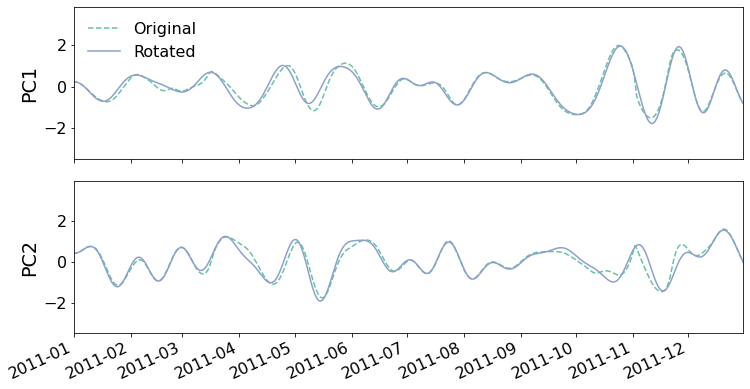

In [26]:
# Figure 4

# specify plotting period
start_date=np.datetime64("2011-01-01") 
end_date=np.datetime64("2011-12-31")

orig_pcs = pcs_norot
calc_pcs = pcs_rot

colors = [(102/255,194/255,165/255), 
          (141/255,160/255,203/255)] #https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3

fig, axs = plt.subplots(2, 1, clear=True, figsize=(12, 6), sharex=True)
plt.subplots_adjust(hspace=0.15)

ax = axs[0]
#ax.set_title("Principal Component 1")
p1, = ax.plot(orig_pcs.time, orig_pcs.pc1, color=colors[0], linestyle='--', label="Original")
p2, = ax.plot(calc_pcs.time, calc_pcs.pc1, color=colors[1], label="Rotated")
if start_date is not None and end_date is not None:
    ax.set_xlim((start_date, end_date))
    ax.set_ylabel("PC1", size='large')
    plt.setp(ax.get_xticklabels(), rotation=25, horizontalalignment='right')
    #fig.legend(handles=(p1, p2), loc='center right', frameon=False, bbox_to_anchor=(1.1,.5))
    ax.legend(handles=(p1, p2), loc='upper left', frameon=False)

ax = axs[1]
#ax.set_title("Principal Component 2")
p3, = ax.plot(orig_pcs.time, orig_pcs.pc2, color=colors[0], linestyle='--', label="Original")
p4, = ax.plot(calc_pcs.time, calc_pcs.pc2, color=colors[1], label="Rotated")
if start_date is not None and end_date is not None:
    ax.set_xlim((start_date, end_date))
    ax.set_ylabel("PC2", size='large')
    plt.setp(ax.get_xticklabels(), rotation=25, horizontalalignment="right")
  
# calculate and print correlation between original and rotated PCs for period
mask = np.logical_and(orig_pcs.time >= start_date, orig_pcs.time <= end_date)
corr_pc1 = np.corrcoef(orig_pcs.pc1[mask], calc_pcs.pc1[mask])[0, 1]
corr_pc2 = np.corrcoef(orig_pcs.pc2[mask], calc_pcs.pc2[mask])[0, 1]
print('Correlation between original and rotated PC1 and PC2 for this time period are: ', corr_pc1, corr_pc2)

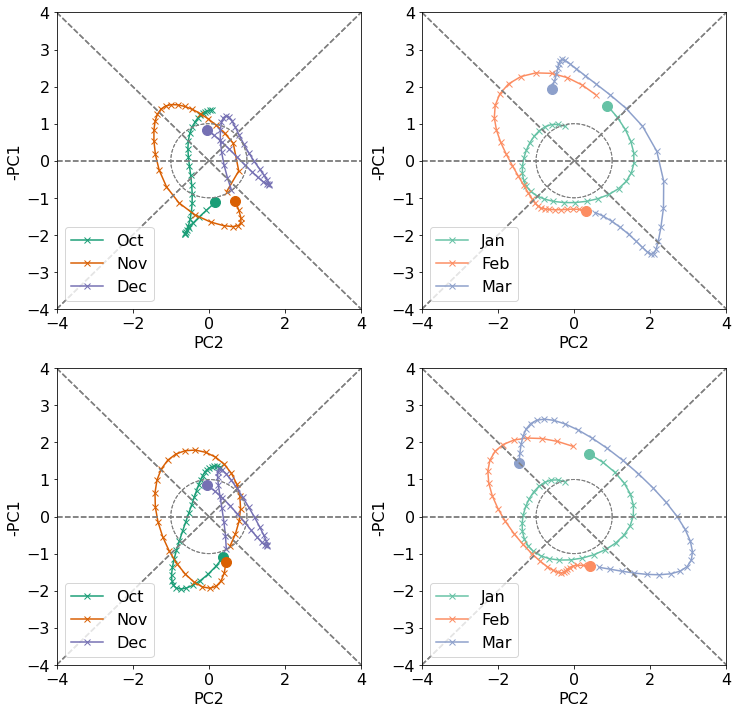

In [13]:
# Figure 5

mon_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# specify months to plot
mons_JFM = [1,2,3]
mons_OND = [10,11,12]

# specify winter season to plot
winter_start = 2011
winter_end = 2012

color_set_JFM = [(102/255,194/255,165/255), 
                  (252/255,141/255,98/255), 
                  (141/255,160/255,203/255)] # https://colorbrewer2.org/#type=qualitative&scheme=Set2&n=3

color_set_OND = [(27/255,158/255,119/255),
                (217/255,95/255,2/255),
                (117/255,112/255,179/255)] # https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3

# for creating grid
x = np.linspace(-4,4,100)
y1 = x
y2 = -x
t = np.linspace(0,np.pi*2,100)

orig_pcs = pcs_norot_org
rot_pcs = pcs_rot_org

pcs_set = [orig_pcs, rot_pcs]
row_lab = ['Original', 'Rotated']

fig, axs = plt.subplots(2, 2, clear=True, figsize=(12, 12))

for i, pcs in enumerate(pcs_set):

    # plot the phase diagram for each month in a different color
    for m in range(len(mons_OND)):
        color = color_set_OND[m]
        axs[i,0].plot(pcs.PC2[(pcs.Month == mons_OND[m]) & (pcs_norot_org.Year == winter_start)], 
                      -pcs.PC1[(pcs.Month == mons_OND[m]) & (pcs_norot_org.Year == winter_start)], 
                      'x-', color=color, label=mon_names[mons_OND[m]-1])
        axs[i,0].plot(pcs.PC2[(pcs.Month == mons_OND[m]) & (pcs_norot_org.Year == winter_start)].values[-1], 
                      -pcs.PC1[(pcs.Month == mons_OND[m]) & (pcs_norot_org.Year == winter_start)].values[-1], 
                      color=color, marker='o', markersize='10')
        axs[i,0].legend(loc='lower left')
    
    # add large dots at end of each month
    for m in range(len(mons_OND)):
        color = color_set_JFM[m]
        axs[i,1].plot(pcs.PC2[(pcs.Month == mons_JFM[m]) & (pcs_norot_org.Year == winter_end)], 
                      -pcs.PC1[(pcs.Month == mons_JFM[m]) & (pcs_norot_org.Year == winter_end)], 
                      'x-', color=color, label=mon_names[mons_JFM[m]-1])
        axs[i,1].plot(pcs.PC2[(pcs.Month == mons_JFM[m]) & (pcs_norot_org.Year == winter_end)].values[-1], 
                      -pcs.PC1[(pcs.Month == mons_JFM[m]) & (pcs_norot_org.Year == winter_end)].values[-1], 
                      color=color, marker='o', markersize='10')
        axs[i,1].legend(loc='lower left')
        
    axs_flat = axs.flatten()

    for ax in axs_flat:   
    
        ax.set_xlabel('PC2')
        ax.set_ylabel('-PC1')

        # create background grid and unit circle
        ax.plot(np.cos(t), np.sin(t), 'grey', linewidth=1, linestyle='dashed')
        ax.plot(x,y1, 'gray', linestyle='dashed')
        ax.plot(x,y2, 'gray', linestyle='dashed')
        ax.plot(x, [0]*len(x), 'gray', linestyle='dashed')

        ax.set_xlim([-4,4])
        ax.set_ylim([-4,4])


Creating the Supplementary gif may take some time to run.

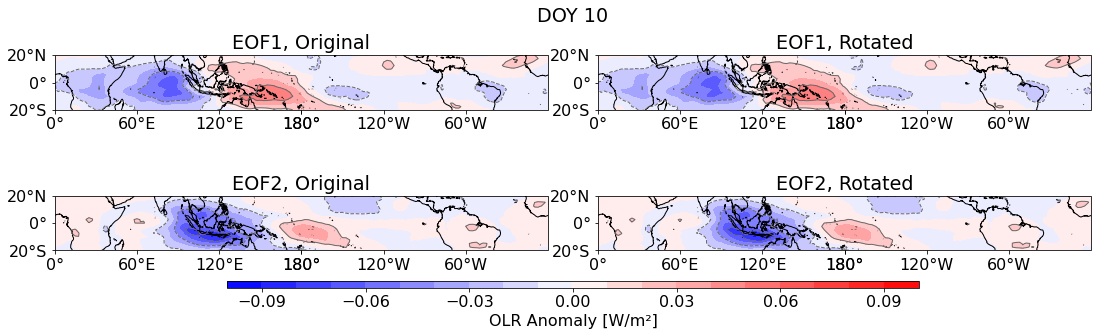

In [15]:
# Supplement: Gif

orig_lat = doy1.lat
orig_long = doy1.long

orig_type = norot_eofs
rot_type = rot_eofs

list_of_doys = tools.doy_list()

blank_map = np.zeros([orig_lat.size, orig_long.size])
blank_map_cyclic, long = add_cyclic_point(blank_map, coord=orig_long)

eof_nums = ['EOF1, Original', 'EOF1, Rotated', 'EOF2, Original', 'EOF2, Rotated']

fig, axs = plt.subplots(2,2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(16,5))

axs = axs.flatten()

# initialize figure
def init_ani():
    
    for i, eof_i in enumerate(eof_nums):
        
        e = axs[i].contourf(long, orig_lat, blank_map_cyclic,
                      levels=np.arange(-0.1, 0.11, 0.01), cmap=plt.cm.get_cmap("bwr"), 
                      transform=ccrs.PlateCarree())
        
        axs[i].coastlines()
        axs[i].set_title(eof_i)
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(orig_lat[::8], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
    
    fig.suptitle(f'DOY 0')
    
    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

    # Draw the colorbar
    cbar=fig.colorbar(e, cax=cbar_ax,orientation='horizontal', label="OLR Anomaly [W/m²]")

# plot map of EOFs for each DOY
def animation_func(frame):
    
    doyn_orig = orig_type.eofdata_for_doy(frame)
    doyn_rot = rot_type.eofdata_for_doy(frame)
    
    eof1_rot_cyclic = add_cyclic_point(doyn_rot.eof1map, axis=1)
    eof2_rot_cyclic = add_cyclic_point(doyn_rot.eof2map, axis=1)
    eof1_orig_cyclic = add_cyclic_point(doyn_orig.eof1map, axis=1)
    eof2_orig_cyclic = add_cyclic_point(doyn_orig.eof2map, axis=1)
        
    axs[0].cla()
    axs[0].contour(long, orig_lat, eof1_orig_cyclic, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.1, 0.11, 0.03), transform=ccrs.PlateCarree())
    axs[0].contourf(long, orig_lat, eof1_orig_cyclic,
             levels=np.arange(-0.1, 0.11, 0.015), cmap=plt.cm.get_cmap("bwr"), transform=ccrs.PlateCarree())

    axs[1].cla()
    axs[1].contour(long, orig_lat, eof1_rot_cyclic, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.1, 0.11, 0.03), transform=ccrs.PlateCarree())
    axs[1].contourf(long, orig_lat, eof1_rot_cyclic,
             levels=np.arange(-0.1, 0.11, 0.015), cmap=plt.cm.get_cmap("bwr"), transform=ccrs.PlateCarree())
    
    axs[2].cla()
    axs[2].contour(long, orig_lat, eof2_orig_cyclic, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.1, 0.11, 0.03), transform=ccrs.PlateCarree())
    axs[2].contourf(long, orig_lat, eof2_orig_cyclic,
             levels=np.arange(-0.1, 0.11, 0.015), cmap=plt.cm.get_cmap("bwr"), transform=ccrs.PlateCarree())

    axs[3].cla()
    axs[3].contour(long, orig_lat, eof2_rot_cyclic, colors='dimgray', linewidths=1,
                      levels=np.arange(-0.1, 0.11, 0.03), transform=ccrs.PlateCarree())
    axs[3].contourf(long, orig_lat, eof2_rot_cyclic,
             levels=np.arange(-0.1, 0.11, 0.015), cmap=plt.cm.get_cmap("bwr"), transform=ccrs.PlateCarree())
    
    for i, eof_i in enumerate(eof_nums):
        
        axs[i].coastlines()
        axs[i].set_title(eof_i)
    
        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(orig_lat[::8], crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
    
    fig.suptitle(f'DOY {frame}')
  
animated = animation.FuncAnimation(fig, animation_func, frames=list_of_doys, init_func=init_ani)
HTML(animated.to_jshtml())

#animated.save(fig_dir / 'eofs_optimize_bwr_lines.gif', fps=10, dpi=48)